In [1]:
# load from json
import json
from pprint import pprint
import numpy as np
with open('./HapticSharedControl/wheel_setting.json', 'r') as f:
    Wheel_setting = json.load(f)
# pprint(Wheel_setting)
L = abs(Wheel_setting['wheels'][0]['position']['y'] - Wheel_setting['wheels'][2]['position']['y'])
T = abs(Wheel_setting['wheels'][0]['position']['x'] - Wheel_setting['wheels'][1]['position']['x'])
theta1 = np.radians(69.99)
theta2 = np.radians(47.95)

R = (L/np.sin(theta2) + np.sqrt((L/np.tan(theta1) + T)**2 + L**2))/2
R, L, T

(406.345498866564, 300.464477, 166.682792)

# Relation between params

In [2]:
# transform data/log to xlsx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [3]:
columns =  ['transformX', 'transformY', 'transformZ',
            'LocationX', 'LocationY',  'LocationZ',
            'transformRoll', 'transformPitch', 'transformYaw',
            'RotationRoll', 'RotationPitch', 'RotationYaw',
            'VelocityX', 'VelocityY', 'VelocityZ',
            'AngularVelocityX', 'AngularVelocityY', 'AngularVelocityZ',
            'brake_input', 'throttle_input', 'steering_input',
           ]

def plot_data_with_timestamp(df, headers = columns):
    plt.style.use('default')
    plt.figure(figsize=(15, 10))
    
    plot_columns = []
    for col in headers:
        if col in df.columns:
            plot_columns.append(col)

    cols = 3
    rows = int(len(plot_columns) // cols)
    for i in range(len(plot_columns)):
        plt.subplot(rows, cols, i+1)
        plt.plot(df['timestamp_device'] / 1000, df[plot_columns[i]], color='blue')
        # plt.plot(df['frame_number'], df[plot_columns[i]].diff().fillna(0), color='red')
        plt.xlabel('timestamp_device')
        plt.ylabel(plot_columns[i])
        
        plt.tight_layout()
        plt.grid()
        
    plt.show()
    plt.close()

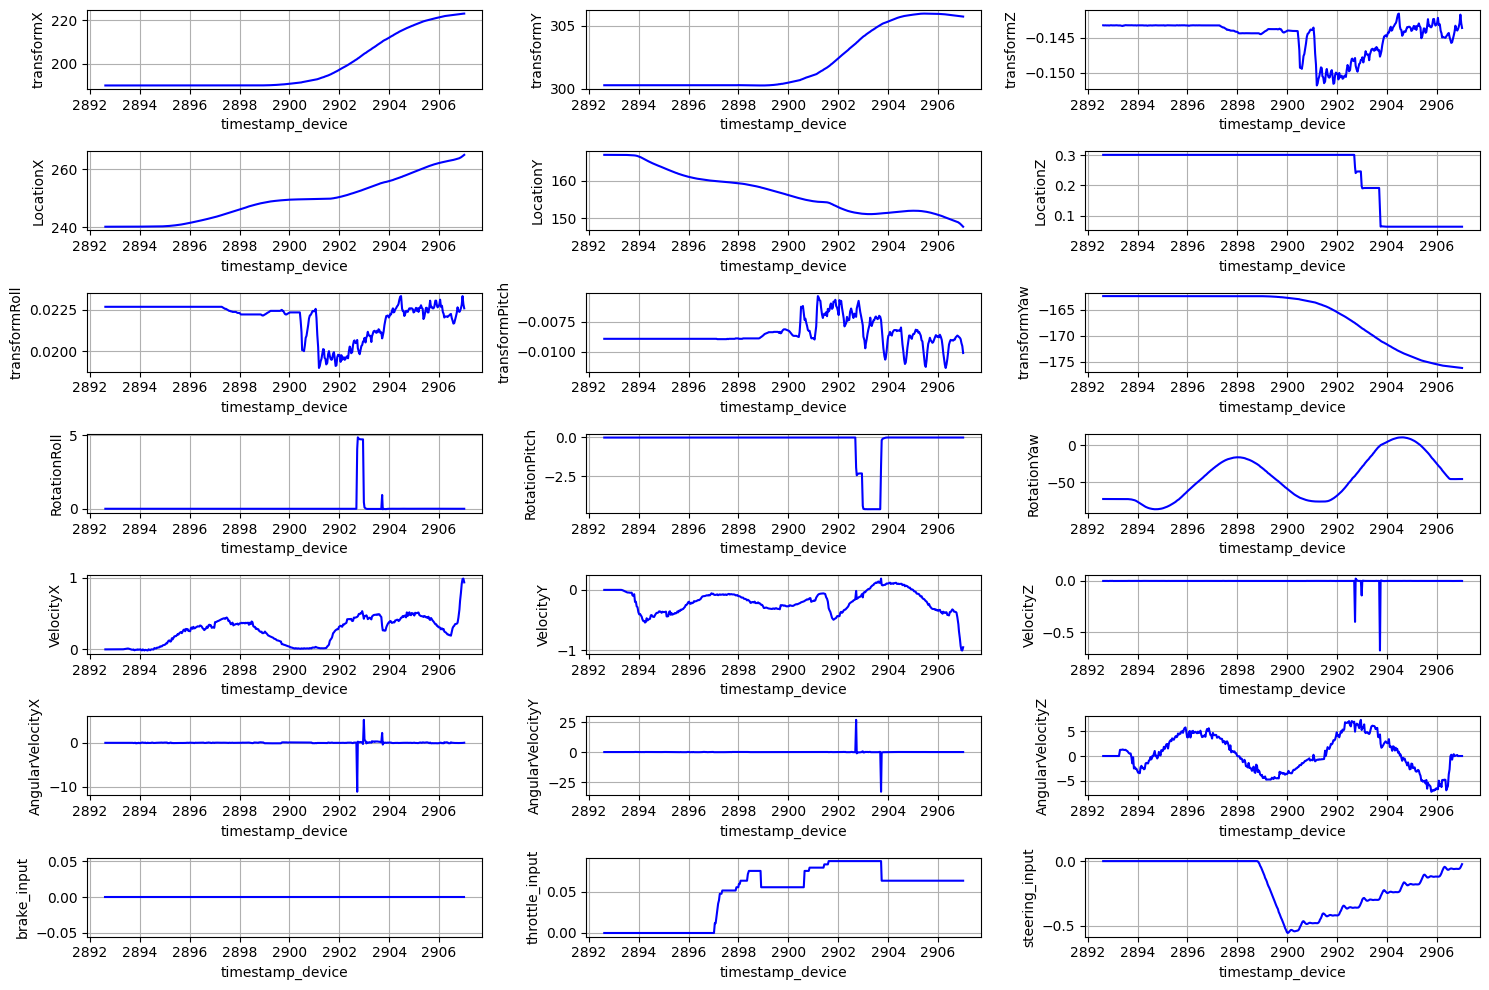

In [4]:
df = pd.read_excel('./data/vehicle_logs/forward_2.xlsx')
plot_data_with_timestamp(df, headers=columns)

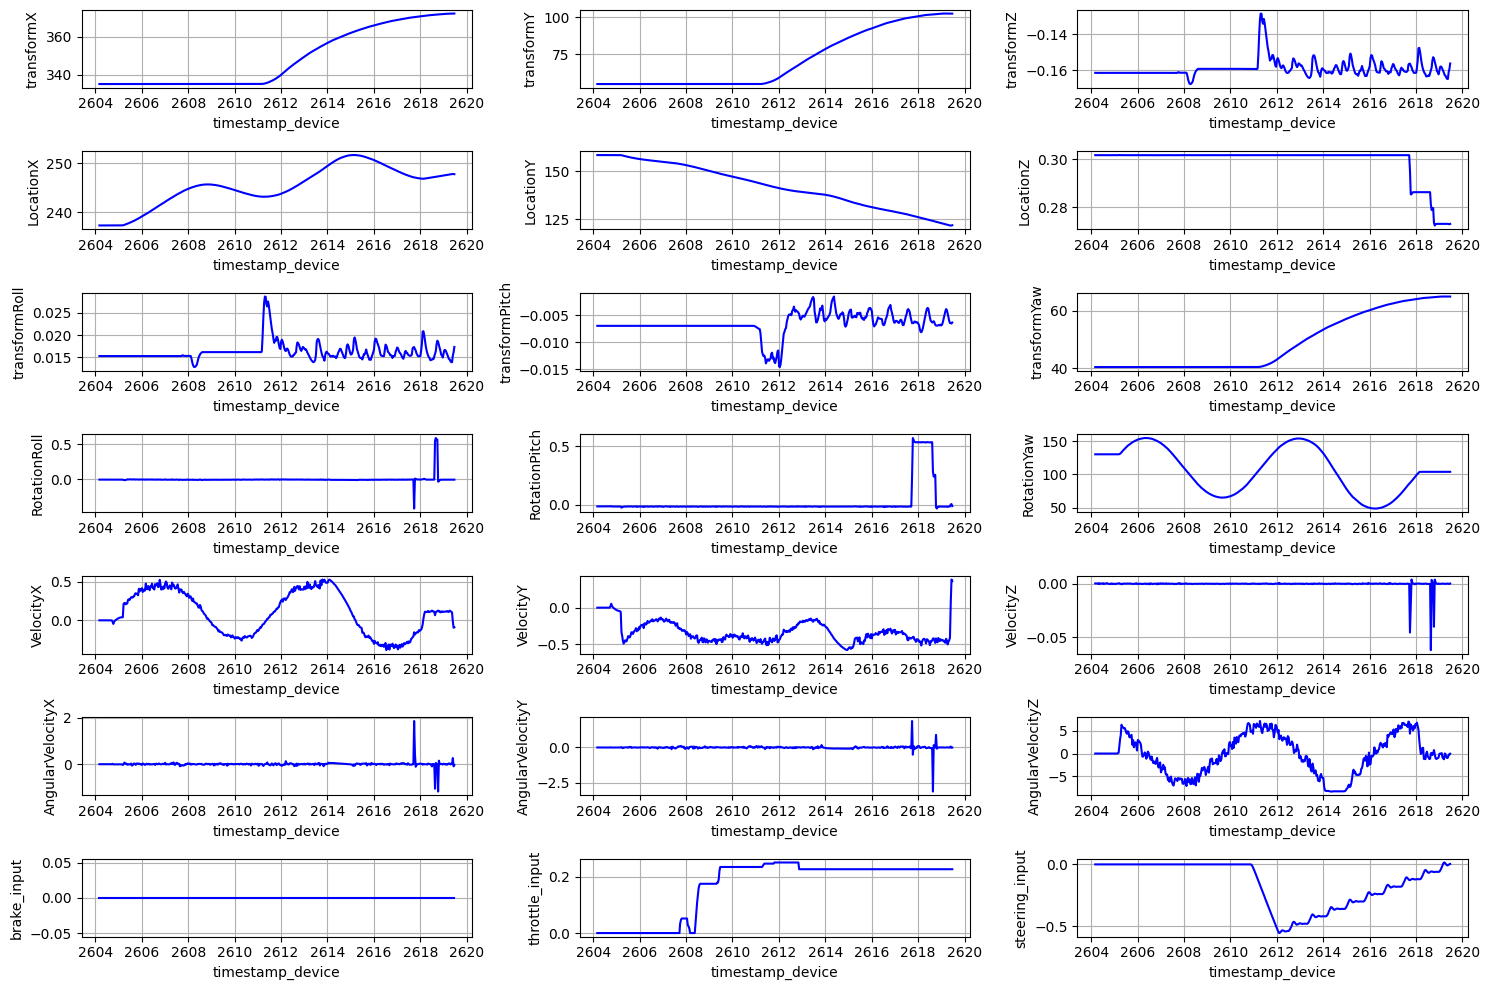

In [4]:
df = pd.read_excel('./data/vehicle_logs/backward_2.xlsx')
plot_data_with_timestamp(df, headers=columns)

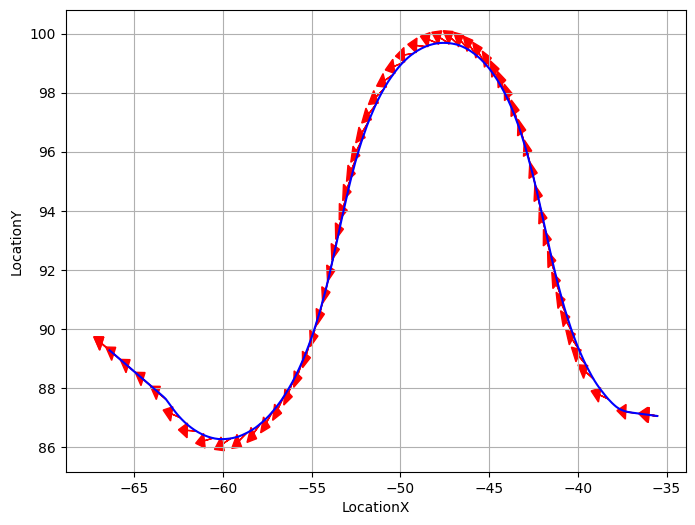

In [6]:
df = pd.read_excel('../data/vehicle_logs/forward_0.xlsx')
plt.figure(figsize=(8, 6))
plt.style.use('default')
plt.plot(df["LocationX"], df["LocationY"], color='blue')
length = 0.5
for idx in range(0, len(df), 10):
    plt.arrow(df["LocationX"].iloc[idx], df["LocationY"].iloc[idx], 
            length * np.cos(np.radians(df["RotationYaw"][idx])), 
            length * np.sin(np.radians(df["RotationYaw"][idx])), 
            head_width=0.5, head_length=0.5, fc='red', ec='red')
plt.xlabel('LocationX')
plt.ylabel('LocationY')
plt.grid()
plt.show()

## Plots from wheel sensor data

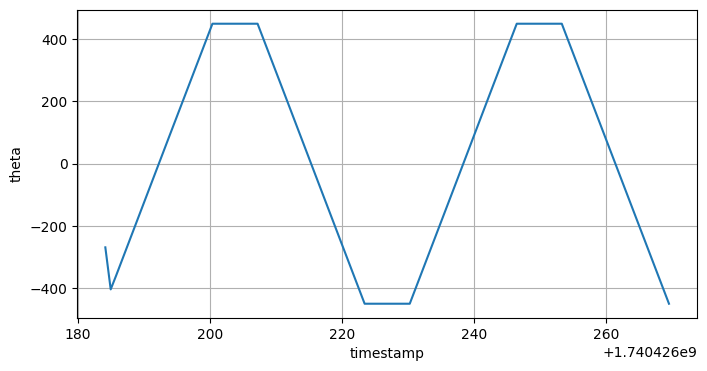

2520


In [5]:
df_spin = pd.read_excel('../data/wheel_logs/spin_test_offset_forward.xlsx')
plt.style.use('default')
df_spin_repeated = df_spin.loc[df_spin.index.repeat(30)].reset_index(drop=True)
df_spin_repeated['timestamp_carla'] = df["timestamp_carla"]
df_spin_repeated['wheel_angle'] =  df_spin_repeated['lX'] * 450 / 32767
plt.figure(figsize=(8, 4))
plt.plot(df_spin_repeated['timestamp'], df_spin_repeated['lX'] * 450 / 32767)
plt.xlabel('timestamp')
plt.ylabel('theta')
plt.grid()
plt.show()
print(len(df_spin_repeated))

## Plots the relationship between measured data
1. Input: (logitech) steering wheel angle offset ~ Measured: (logitech) steering wheel angle
2. Input: (logitech) steering wheel angle ~ Measured: (carla) steering input
3. Input: (carla) steering input ~ Measured: (carla) steering angle 
4. Input: (carla) steering angle ~ Measured: change of yaw angles (vehicle angle)

Linear Relation: Y = 5.071472 * X + -43.396379


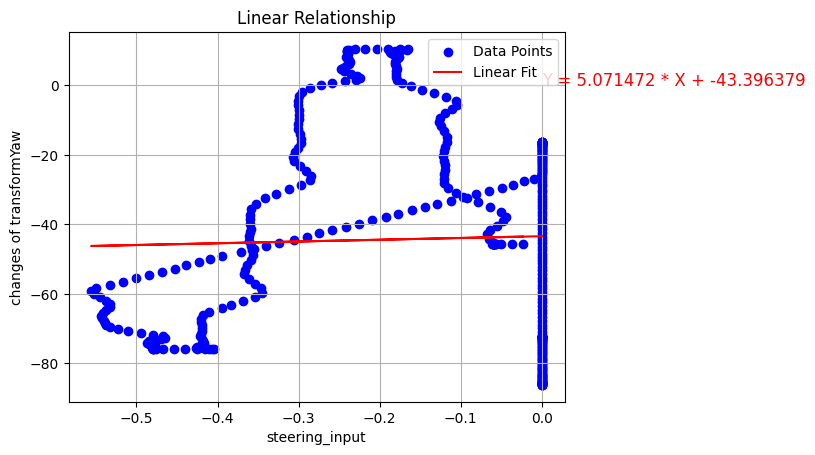

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_excel('./data/vehicle_logs/forward_2.xlsx')
# df = df.iloc[410:410+42*30]
# df = df.iloc[310:310+42*30]

# Extract X and Y
X = df[['LocationX']]  # Feature must be 2D
Y = df['LocationY']  # Target can be 1D
# Linear Regression Model
model = LinearRegression()
model.fit(X, Y)

# Coefficient and Intercept
slope = model.coef_[0]
intercept = model.intercept_

print(f"Linear Relation: Y = {slope:.6f} * X + {intercept:.6f}")

# Predicted Y values
Y_pred = model.predict(X)

# Plot the data and linear fit
# show equation on the plot

plt.scatter(X, Y, color='blue', label='Data Points')
plt.plot(X, Y_pred, color='red', label='Linear Fit')
plt.text(0, 0, f'Y = {slope:.6f} * X + {intercept:.6f}', fontsize=12, color='red')
plt.xlabel('steering_input')
plt.ylabel('changes of transformYaw')
plt.title('Linear Relationship')
plt.legend()
plt.grid(True)
plt.show()


### Plot the path from trial files

Mean P_0=  [ -2.28414266 -31.76363449] std:  [0.69571586 1.59066774]
Mean P_d=  [  1.3190975  -17.71419983] std:  [1.28412121 0.94453664]
Mean P_f=  [ -7.52827587 -21.45773392] std:  [0.24394655 0.18573103]
Mean yaw_0=  1.0251007000000016 std:  3.025966799170614
Mean yaw_d=  51.23525617400001 std:  9.297417441007045
Mean yaw_f=  91.296984836 std:  0.7554986672489944


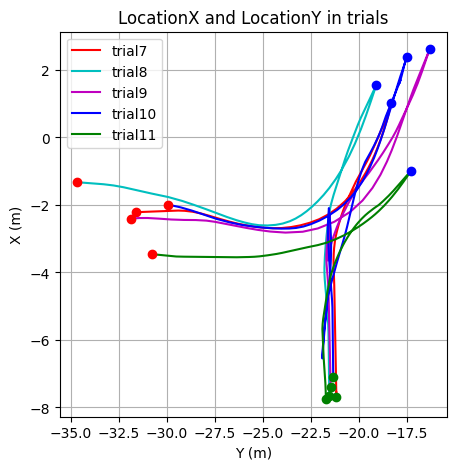

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(5,5))
plt.title('LocationX and LocationY in trials')

backward_range = range(0, 6)
forward_range = range(7, 12)

range_ = forward_range

paths = {}
P_0 = []
P_d = []
P_f = []
yaw_0 = []
yaw_d = []
yaw_f = []

for i in range_:
    df = pd.read_excel(f'../data/trials/trial{i + 1}.xlsx')
    x = df['LocationX'].to_list()
    y = df['LocationY'].to_list()
    yaw = df['RotationYaw'].to_list()
    
    paths[f'trial{i}'] = [(x_t, y_t) for x_t, y_t in zip(x, y)]
    
    P_0.append([x[0], y[0]])
    P_d.append([max(x), y[x.index(max(x))]])
    P_f.append([min(x), y[x.index(min(x))]])
    yaw_0.append(90 - yaw[0])
    yaw_d.append(90 - yaw[x.index(max(x))])
    yaw_f.append(90 - yaw[x.index(min(x))])
        
    plt.plot(y, x, color=colors[i%len(range_)], label=f'trial{i}')
    plt.plot(y[0], x[0], 'ro')
    plt.plot(y[x.index(min(x))], min(x), 'go')
    plt.plot(y[x.index(max(x))], max(x), 'bo') # turning point
    
    # print(f"trial{i} P_0= \t[", x[0],  "\t,", y[0], ']')
    # print(f"trial{i} P_d= \t[", max(x), "\t,", y[x.index(max(x))], ']')
    # print(f"trial{i} P_f= \t[", min(x), "\t,", y[x.index(min(x))], ']')
    # print(f"trial{i} yaw_0= \t", 90 + df['RotationYaw'][0])
    # print(f"trial{i} yaw_d= \t", 90 + df['RotationYaw'][x.index(max(x))])
    # print(f"trial{i} yaw_f= \t", 90 + df['RotationYaw'][x.index(min(x))])

P_0 = np.array(P_0)
P_d = np.array(P_d)
P_f = np.array(P_f)
yaw_0 = np.array(yaw_0)
yaw_d = np.array(yaw_d)
yaw_f = np.array(yaw_f)

print("Mean P_0= ", np.mean(P_0, axis=0), "std: ", np.std(P_0, axis=0))
print("Mean P_d= ", np.mean(P_d, axis=0), "std: ", np.std(P_d, axis=0))
print("Mean P_f= ", np.mean(P_f, axis=0), "std: ", np.std(P_f, axis=0))
print("Mean yaw_0= ", np.mean(yaw_0), "std: ", np.std(yaw_0))
print("Mean yaw_d= ", np.mean(yaw_d), "std: ", np.std(yaw_d))
print("Mean yaw_f= ", np.mean(yaw_f), "std: ", np.std(yaw_f))
    
plt.xlabel('Y (m)')
plt.ylabel('X (m)')

plt.legend()

plt.grid()
plt.show()
plt.close()

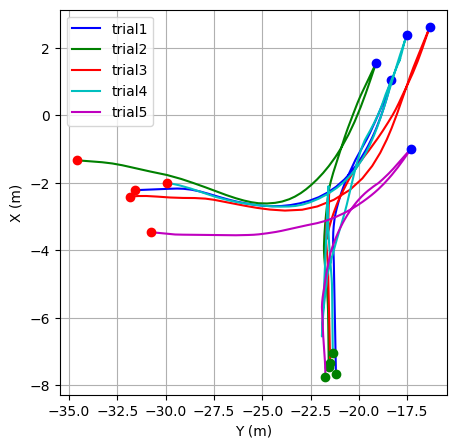

In [4]:
# preprocess paths, remove outliers,and duplicate points
from os import path
from scipy import interpolate
import numpy as np
import pandas as pd

path_data = {}

for i in range_:
    df = pd.read_excel(f'../data/trials/trial{i + 1}.xlsx')
    X = df['LocationX']
    Y = df['LocationY']
   
    P_0 = [X[0], Y[0]]
    P_d = [max(X), Y[X.idxmax()]]
    P_f = [min(X), Y[X.idxmin()]]
    
    for j in range(1, X.idxmax()):
        changes_x = X.diff().fillna(0)[j]
        changes_y = Y.diff().fillna(0)[j]

        if (-1 if range_ == backward_range else 1) * changes_y > 0 and abs(changes_y) > 1e-3:
            path_data.setdefault(f'trial{i + 1}', []).append([X[j], Y[j]])
    
    for j in range(X.idxmax(), X.idxmin()):
        changes_x = X.diff().fillna(0)[j]
        changes_y = Y.diff().fillna(0)[j]
        
        if  changes_x < 0 and abs(changes_x) > 1e-3:
            path_data.setdefault(f'trial{i + 1}', []).append([X[j], Y[j]]) 

plt.figure(figsize=(5,5))
for i in range(len(path_data)):
    path = np.array(path_data[f'trial{i + 1 + list(range_)[0]}'])
    # path = np.unique(path, axis=0)
    x, y = path[:, 0], path[:, 1]
    plt.plot(y, x, color=colors[i], label=f'trial{i + 1}')
    plt.plot(y[0], x[0], 'ro')
    plt.plot(y[np.argmin(x)], min(x), 'go')
    plt.plot(y[np.argmax(x)], max(x), 'bo') 
    
    
plt.xlabel('Y (m)')
plt.ylabel('X (m)')

plt.legend()

plt.grid()
plt.show()
plt.close()

(142, 2)
46 141
Mean P_0=  [-2.284308814, -31.734065629999996]
Mean P_d=  [0.409550333177305, -18.459612079588652]
Mean P_f=  [-7.449310874, -21.459648512]


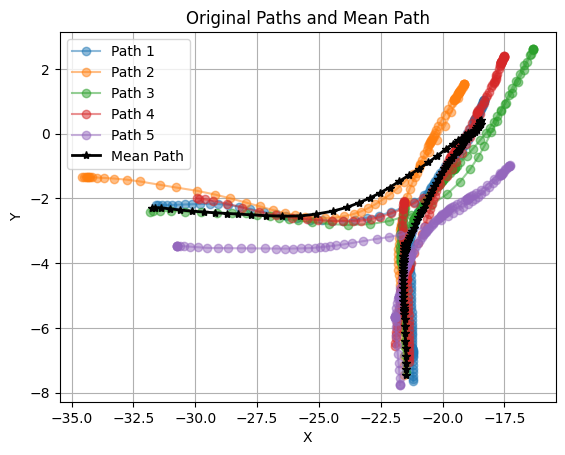

In [5]:

def resample_path(path, num_points):
    """Resample a path to a specified number of points using linear interpolation."""
    # Separate x and y coordinates
    x = np.array([p[0] for p in path])
    y = np.array([p[1] for p in path])
    
    # Create interpolation functions
    t = np.linspace(0, 1, len(path))  # Parameterize original points
    t_new = np.linspace(0, 1, num_points)  # New parameterization
    
    # Interpolate x and y separately
    fx = interpolate.interp1d(t, x, kind='linear')
    fy = interpolate.interp1d(t, y, kind='linear')
    
    x_new = fx(t_new)
    y_new = fy(t_new)
    
    return list(zip(x_new, y_new))

def compute_mean_path(paths, num_points=None):
    """Compute the mean path by resampling all paths and averaging."""
    if num_points is None:
        # Use the length of the longest path by default
        num_points = min(len(path) for path in paths)
    
    # Resample all paths to the same number of points
    resampled_paths = [resample_path(path, num_points) for path in paths]
    
    # Convert to numpy array for easier averaging
    resampled_array = np.array(resampled_paths)  # Shape: (n_paths, num_points, 2)
    
    # Compute mean across paths (axis 0)
    mean_path = np.mean(resampled_array, axis=0)  # Shape: (num_points, 2)
    
    return mean_path

def plot_paths(original_paths, mean_path):
    """Plot original paths and the mean path."""
    plt.figure()
    
    # Plot original paths
    for i, path in enumerate(original_paths):
        x, y = zip(*path)
        plt.plot(y, x, 'o-', label=f'Path {i+1}', alpha=0.5)
    
    # Plot mean path
    x_mean, y_mean = zip(*mean_path)
    P_0 = [x_mean[0], y_mean[0]]
    P_d = [max(x_mean), y_mean[np.argmax(x_mean)]]
    P_f = [min(x_mean), y_mean[np.argmin(x_mean)]]
    print(np.argmax(x_mean), np.argmin(x_mean))
    print("Mean P_0= ", P_0)
    print("Mean P_d= ", P_d)
    print("Mean P_f= ", P_f)
    plt.plot(y_mean, x_mean, 'k*-', label='Mean Path', linewidth=2)
    
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Paths and Mean Path')
    plt.grid(True)
    plt.show()
    
# Compute the mean path
mean_path = compute_mean_path(path_data.values())
print(mean_path.shape)
# Display results
# print("Mean Path:")
# for point in mean_path:
#     print(point)
with open('../data/paths/driving_path_right2left.txt', 'w') as f:
    for point in mean_path:
        f.write(f"{point[0]},{point[1]}\n")

# Visualize
plot_paths(path_data.values(), mean_path)

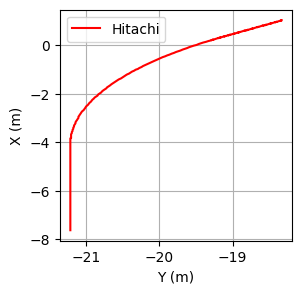

In [11]:
with open('../PythonAPI/data/paths/hitachi.txt', 'r') as f:
    lines = f.readlines()
    hitachi_path = []
    for line in lines:
        x, y = line.strip().split(',')
        hitachi_path.append([float(x), float(y)])
    hitachi_path = np.array(hitachi_path)

plt.figure(figsize=(3, 3))
x, y = hitachi_path[:, 0], hitachi_path[:, 1]
plt.plot(y, x, 'r', label='Hitachi')
# plt.plot(y[0], x[0], 'ro')
# plt.plot(y[np.argmin(x)], min(x), 'go')
# plt.plot(y[np.argmax(x)], max(x), 'bo')
plt.xlabel('Y (m)')
plt.ylabel('X (m)')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [3]:
import numpy as np

def compute_tangents(points):
    tangents = []
    n = len(points)

    for i in range(n):
        if i == 0:
            dx, dy = points[i + 1][0] - points[i][0], points[i + 1][1] - points[i][1]
        elif i == n - 1:
            dx, dy = points[i][0] - points[i - 1][0], points[i][1] - points[i - 1][1]
        else:
            dx, dy = points[i + 1][0] - points[i - 1][0], points[i + 1][1] - points[i - 1][1]

        scale = 1
        p1 = (points[i][0] - scale * dx, points[i][1] - scale * dy)
        p2 = (points[i][0] + scale * dx, points[i][1] + scale * dy)

        tangents.append((p1, p2))

    return tangents



def process_exist_path(path):
    """
    Process an existing path consisting of a series of points and compute
    tangent vectors at each point along the path.

    Args:
        path: A list or numpy array of [x,y] coordinates that form a path

    Returns:
        param: Dictionary containing the original path and computed tangent vectors
    """
    path = np.array(path)
    param = {
        "path": path,
        "start_x": path[0][0],
        "start_y": path[0][1],
        "end_x": path[-1][0],
        "end_y": path[-1][1],
        "tangent": compute_tangents(path),
    }

    return param

with open("../data/paths/driving_path_left2right.txt", "r") as f:
    data_left2right = f.readlines()
    data_left2right = [line.strip().split(",") for line in data_left2right]
    data_left2right = [[float(val) for val in line] for line in data_left2right]
    data_left2right = np.array(data_left2right)

with open("../data/paths/driving_path_right2left.txt", "r") as f:
    data_right2left = f.readlines()
    data_right2left = [line.strip().split(",") for line in data_right2left]
    data_right2left = [[float(val) for val in line] for line in data_right2left]
    data_right2left = np.array(data_right2left)

with open("../data/paths/hitachi.txt", "r") as f:
    data_hitachi = f.readlines()
    data_hitachi = [line.strip().split(",") for line in data_hitachi]
    data_hitachi = [[float(val) for val in line] for line in data_hitachi]
    data_hitachi = np.array(data_hitachi)



predefined_path = {
    "0": {
        "P_0": [-1.47066772, -13.22415039],
        "P_d": [-0.37066772, -29.02415039],
        "P_f": [-6.87066772, -21.62415039],
        "yaw_0": 90 - (-90),
        "yaw_d": 90 - (-80),
        "yaw_f": 90 - 0,
        "forward paths": None,
        "backward paths": None,
    },
    "1": {
        "P_0": [-2.376371583333333, -13.749357381666668],
        "P_d": [-0.566469992644628, -27.297582133636364],
        "P_f": [-7.7486732, -21.271947543333333],
        "yaw_0": 90 - (88.97628786666667),
        "yaw_d": 90 - (62.168829599999995),
        "yaw_f": 90 - (-1.9554259149999922),
        "forward paths": process_exist_path(data_left2right[:40]),
        "backward paths": process_exist_path(data_left2right[40:]),
    },
    "2": {
        "P_0": [-2.284308814, -31.734065629999996],
        "P_d": [0.409550333177305, -18.459612079588652],
        "P_f": [-7.449310874, -21.459648512],
        "yaw_0": 90 - (-88.9748993),
        "yaw_d": 90 - (-38.76474382600003),
        "yaw_f": 90 - (1.296984835999993),
        "forward paths": process_exist_path(data_right2left[:46]),
        "backward paths": process_exist_path(data_right2left[46:]),
    },
    "3": {
        "P_0": [],
        "P_d": [1.035116, -18.325821],
        "P_f": [-7.685114, -21.214608],
        "yaw_0": None,
        "yaw_d": 90 - (50),
        "yaw_f": 90 - (0),
        "forward paths": [],
        "backward paths": process_exist_path(data_hitachi),
    },
}
# predefined_path["1"]["forward paths"]

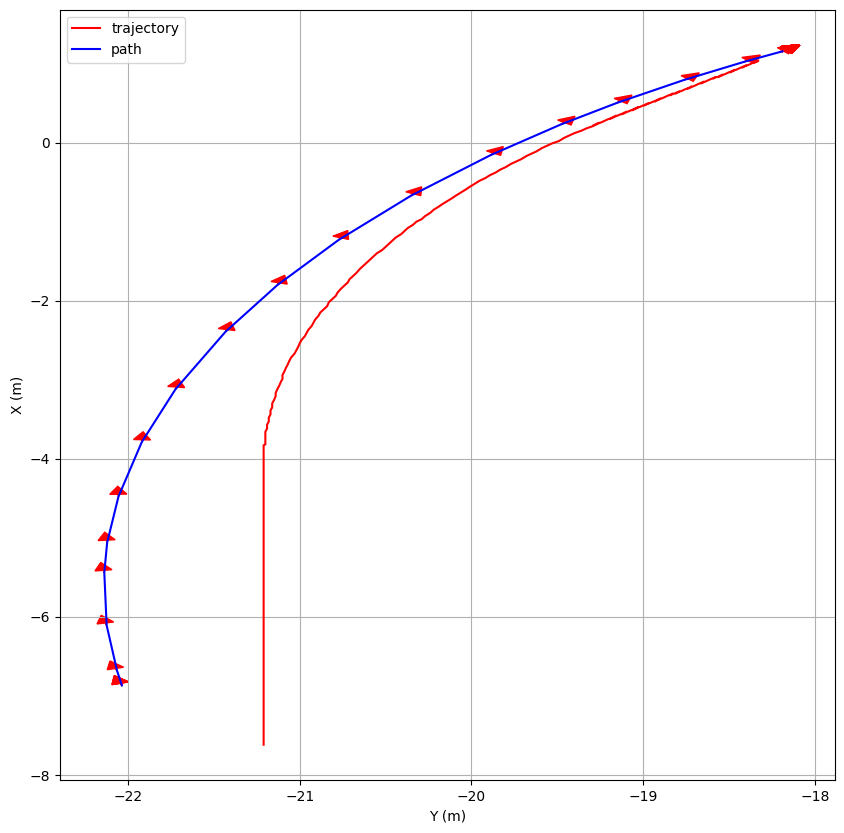

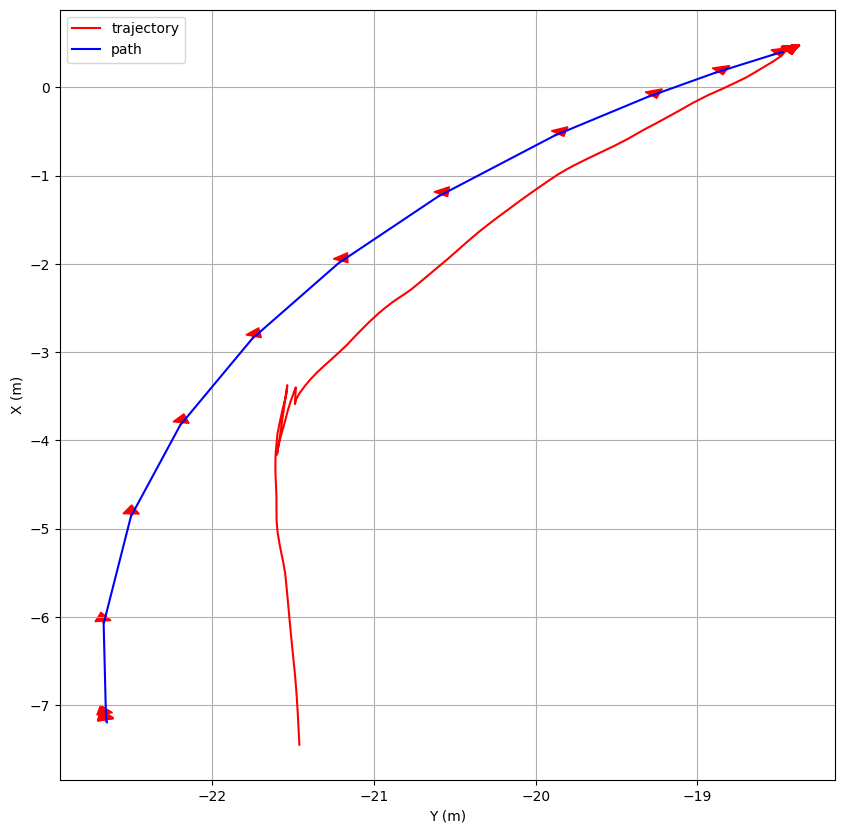

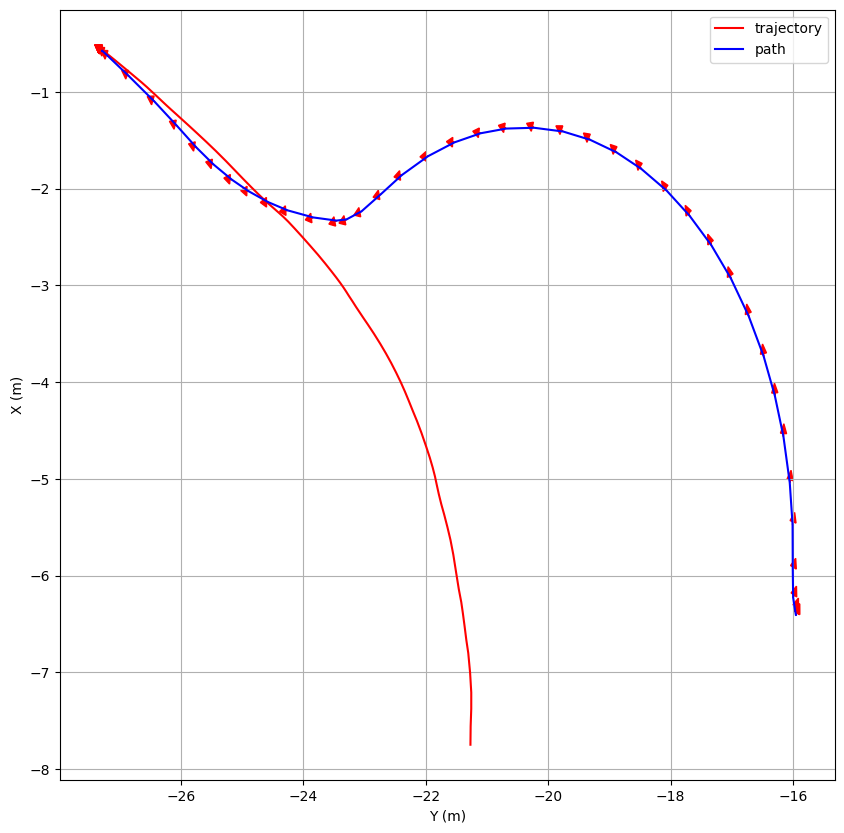

In [11]:
import matplotlib.pyplot as plt
plt.style.use('default')

for i in range(3):
    log_file = f"./log{i + 1}.txt"
    with open(log_file, "r") as f:
        data = f.readlines()
        data = [line.strip().split(",") for line in data]
        data = [[float(val) for val in line[:3]] for line in data]
        data = np.array(data)
        
    trajectory = predefined_path[str(3 - i)]["backward paths"]["path"]
    # plot the path and the trajectory
    plt.figure(figsize=(10, 10))
    plt.plot(trajectory[:, 1], trajectory[:, 0], 'r', label='trajectory')
    plt.plot(data[:, 1], data[:, 0], 'b', label='path')
    for i, (x, y) in enumerate(zip(data[:, 1], data[:, 0])):
        plt.arrow(x, y, 
            0.03 * np.cos(np.radians(90 - data[:, 2][i])), 
            0.03 * np.sin(np.radians(90 - data[:, 2][i])), 
            head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.xlabel('Y (m)')
    plt.ylabel('X (m)')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    

## **Bezier curve**



In [9]:
from HapticSharedControl.path_planning import *
import matplotlib.pyplot as plt
plt.style.use('default')

P_0 = [-147.066772, -1322.415039] # [y, x]
P_f = [-687.066772, -2162.415039]
P_d = [-37.066772 , -2902.415039]

yaw_0 = 0
yaw_d = 10
yaw_f = 90

vel = 2.0 # km/h

# #plot points
# plt.figure()

# plt.plot(P_0[1], P_0[0], 'go')
# plt.plot(P_d[1], P_d[0], 'bo')
# plt.plot(P_f[1], P_f[0], 'ro')
# plt.grid()

# plt.show()

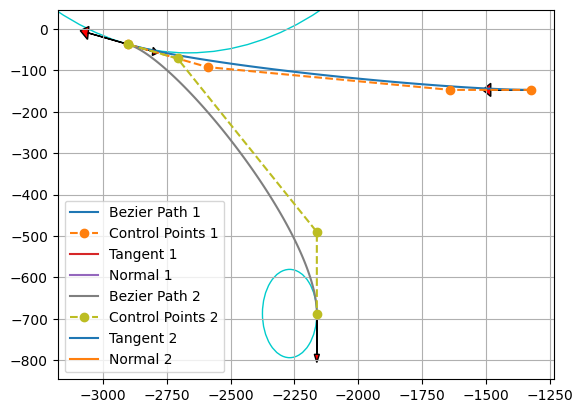

In [10]:
n_points = 100
path1, control_points1, params1 = calculate_bezier_trajectory(
    start_pos=P_0[::-1],
    end_pos=P_d[::-1],
    start_yaw=yaw_0,
    end_yaw=yaw_d,
    n_points=n_points,
    turning_radius=R,
    show_animation=False,
)
# backward so reverse the yaw angle (+180)
path2, control_points2, params2 = calculate_bezier_trajectory(
    start_pos=P_d[::-1],
    end_pos=P_f[::-1],
    start_yaw=180 + yaw_d,
    end_yaw=180 + yaw_f,
    n_points=n_points,
    turning_radius=R,
    show_animation=False,
)

# show 2 path in same plot
plt.figure()
plt.plot(path1.T[0], path1.T[1], label="Bezier Path 1")
plt.plot(control_points1.T[0], control_points1.T[1], "--o", label="Control Points 1")
plt.plot(params1["x_target"], params1["y_target"])
plt.plot(params1["tangent"][-1][:, 0], params1["tangent"][-1][:, 1], label="Tangent 1")
plt.plot(params1["normal"][-1][:, 0], params1["normal"][-1][:, 1], label="Normal 1")
plt.gca().add_artist(params1["circle"])
plot_arrow(
    params1["start_x"],
    params1["start_y"],
    np.pi - params1["start_yaw"],
    length=0.1 * params1["dist"],
    width=0.02 * params1["dist"],
)
plot_arrow(
    params1["end_x"],
    params1["end_y"],
    np.pi - params1["end_yaw"],
    length=0.1 * params1["dist"],
    width=0.02 * params1["dist"],
)

plt.plot(path2.T[0], path2.T[1], label="Bezier Path 2")
plt.plot(control_points2.T[0], control_points2.T[1], "--o", label="Control Points 2")
plt.plot(params2["x_target"], params2["y_target"])
plt.plot(params2["tangent"][-1][:, 0], params2["tangent"][-1][:, 1], label="Tangent 2")
plt.plot(params2["normal"][-1][:, 0], params2["normal"][-1][:, 1], label="Normal 2")
plt.gca().add_artist(params2["circle"])
plot_arrow(
    params2["start_x"],
    params2["start_y"],
    np.pi - params2["start_yaw"],
    length=0.1 * params2["dist"],
    width=0.02 * params2["dist"],
)
plot_arrow(
    params2["end_x"],
    params2["end_y"],
    np.pi - params2["end_yaw"],
    length=0.1 * params2["dist"],
    width=0.02 * params2["dist"],
)

plt.legend()
plt.grid(True)
plt.show()
plt.close()

## Haptic shared control

In [11]:
from HapticSharedControl.utils import *
from HapticSharedControl.haptic_algo import *

In [ ]:
time_step = 1.0
path = path2
param = params2

vehicle_config = Wheel_setting

i_points = P_d[::-1]
f_points = P_f[::-1]
i_yaw = 180 + yaw_d

# Simulation Parameters
# speed = int((f_points[0] - i_points[0]) // 100)
speed = -2
init_steering_angle = 10.0

n_steps = None

current_position = i_points
# Haptic Shared Control Initialization
haptic_control = HapticSharedControl(
    Cs=0.5,
    Kc=0.5,
    T=2,
    tp=1,
    speed=speed,
    desired_trajectory_params=param,
    vehicle_config=vehicle_config,
)

# Simulation Loop
print("Starting Simulation")

s_angleL = init_steering_angle
s_angleR = init_steering_angle

trajectory = [current_position]
torques = []
steering_angles_deg = [init_steering_angle]

yaw_angles_deg = [i_yaw]  # if change sign of swa, change sign here

# Calculate the torque at each step
step = 0
distances = [np.float("inf")]
while True:
    print("--------------------")
    print("Step:", step)

    torque, coef, desired_steering_angle_deg = haptic_control.calculate_torque(
        current_position=current_position,
        steering_angles_deg=[s_angleL, s_angleR],
        current_yaw_angle_deg=i_yaw,
    )

    next_position = haptic_control.rtp

    torques.append(torque)
    trajectory.append(next_position)

    steering_angles_deg.append(desired_steering_angle_deg)
    yaw_angles_deg.append(haptic_control.predict_yaw_angle_deg)

    s_angleL = np.clip(desired_steering_angle_deg, -47.95, 69.99)
    s_angleR = np.clip(desired_steering_angle_deg, -69.99, 47.95)
    # s_angleL = desired_steering_angle_deg
    # s_angleR = desired_steering_angle_deg
    i_yaw = haptic_control.predict_yaw_angle_deg
    current_position = next_position

    step += 1
    if n_steps is not None and step >= n_steps:
        break
    else:
        # consider the point as reached if the distance is less than 0.1
        dist_t = dist(current_position, f_points)
        if dist_t > distances[-1]:
            trajectory.pop(-1)
            torques.pop(-1)
            steering_angles_deg.pop(-1)
            yaw_angles_deg.pop(-1)
            print("Distance increased so stop the simulation")
            break
        distances.append(dist_t)

# Extract trajectory points
trajectory = np.array(trajectory)
x_points = trajectory[:, 0]
y_points = trajectory[:, 1]

# Plot the trajectory

# plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, label="Predicted Path", color="red")
plt.plot(path[:, 0], path[:, 1], "--", label="Bezier Path")
plt.xlabel("Y")
plt.ylabel("X")
plt.title("Vehicle Path and Bezier Trajectory")
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, current_time, time_step), torques, label="Torque")
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Torque Feedback")
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, current_time, time_step), steering_angles[:-1], label="Steering Angle")
plt.xlabel("Time (s)")
plt.ylabel("Steering angle (rad)")
plt.title("Steering angle")
plt.grid(True)
plt.show()

TypeError: calculate_torque() got an unexpected keyword argument 'current_yaw_angle'

Turning Radius: 17.067320741631864
Rotating Direction: CW
[Vehicle] Center of Rotation in Vehicle: [-17.014  -1.35 ]
[World] Center of Rotation: [-30.649 -17.36 ]
Turning Angle: -4.536751165357343
Delta Phi: 6.714091846100043
Predicted Yaw Angle: 176.71409184610005
Predicted Position: [-31.022  -0.297]
Delta phi (graph): 6.714091846100045


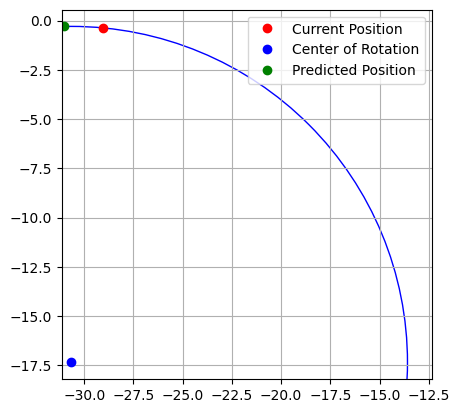

In [3]:
# test predict position
import numpy as np
import math
import matplotlib.pyplot as plt

plt.style.use("default")


def rotation_matrix_cw(angle_rad):
    return np.array(
        [[np.cos(angle_rad), -np.sin(angle_rad)], [np.sin(angle_rad), np.cos(angle_rad)]]
    )

def getAngle(a, b, c, degrees=False):
    angle_rad = math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0])
    return math.degrees(angle_rad) if degrees else angle_rad

def predict_position(current_position, current_yaw_angle_deg, vehicle_steering_angle_deg, vel=2, tp=1):
    wheelbase = 3  # meter
    tire_width = 1.67  # meter
    current_yaw_angle_rad = np.radians(current_yaw_angle_deg)
    vehicle_steering_angle_rad = np.radians(vehicle_steering_angle_deg)

    center_of_mass = 0.45 * wheelbase

    # turning_radius = wheelbase / np.sin(abs(vehicle_steering_angle_rad)) # meter
    turning_radius = np.sqrt(center_of_mass ** 2  + wheelbase ** 2 / np.tan(vehicle_steering_angle_rad) ** 2)
    turning_angle_rad = np.arctan(0.45 * np.tan(vehicle_steering_angle_rad))
    
    print("Turning Radius:", turning_radius)
    # vehicle coordinates, origin at the center of mass
    rotating_direction =  np.sin(vehicle_steering_angle_rad) / np.abs(
        np.sin(vehicle_steering_angle_rad)
    )  #  -1 if clockwise, 1 if counter-clockwise
    print("Rotating Direction:", "CW" if rotating_direction == -1 else "CCW")
    
    center_of_rotation_with_vehicle = np.array(
        [
            wheelbase / np.tan(vehicle_steering_angle_rad),
            -center_of_mass,
        ]
    )
    print("[Vehicle] Center of Rotation in Vehicle:", center_of_rotation_with_vehicle.round(3))
    # transform the vehicle coordinates to the global coordinates, rotate and shift
    center_of_rotation_with_world = rotation_matrix_cw(current_yaw_angle_rad   - np.pi / 2).dot(
        center_of_rotation_with_vehicle
    ) + np.array(current_position)
    print("[World] Center of Rotation:", center_of_rotation_with_world.round(3))
    # print("Distance from Center of Rotation to Vehicle:", np.linalg.norm(center_of_rotation_with_world - current_position))
    # print("Angle:", np.degrees(np.arctan(current_position[1] / center_of_rotation_with_world[0])))
    # changes of vehicle angle
    # turning_angle_rad = rotating_direction * vehicle_steering_angle_rad + current_yaw_angle_rad

    # # rotating around the center of rotation
    # rotating_angle_rad = turning_angle_rad - np.pi / 2
    print("Turning Angle:", np.degrees(turning_angle_rad))
    # calculate the predicted position
    delta_phi_rad = - rotating_direction * vel * tp / turning_radius
    # delta_phi_rad = - angular_speed * tp
    delta_phi_deg = np.degrees(delta_phi_rad)
    print("Delta Phi:", delta_phi_deg)
    
    # predict_yaw_angle_deg = current_yaw_angle_deg + delta_phi_deg

    predict_yaw_angle_rad = current_yaw_angle_rad + delta_phi_rad
    predict_yaw_angle_deg = np.degrees(predict_yaw_angle_rad)

    print("Predicted Yaw Angle:", predict_yaw_angle_deg)
    
    predicted_position_in_world = center_of_rotation_with_world + turning_radius * np.array(
        [
            np.cos(predict_yaw_angle_rad - turning_angle_rad + rotating_direction * np.pi/2),
            np.sin(predict_yaw_angle_rad - turning_angle_rad + rotating_direction * np.pi/2),
        ]
    )
    
    print("Predicted Position:", predicted_position_in_world.round(3))
    print("Delta phi (graph):", getAngle(current_position, center_of_rotation_with_world, predicted_position_in_world, degrees=True))

    return predicted_position_in_world, center_of_rotation_with_world


position = [-29.02415039, -0.37066772]
yaw = 170
steering_angle = -10
vel = 2
tp = 1

position_next, cow = predict_position(position, yaw, steering_angle, vel=vel, tp=tp)

plt.plot(position[0], position[1], "ro", label="Current Position")
plt.plot(cow[0], cow[1], "bo", label="Center of Rotation")
plt.plot(position_next[0], position_next[1], "go" , label="Predicted Position")
circle = plt.Circle(
    cow, math.hypot(cow[0] - position[0], cow[1] - position[1]), color="b", fill=False
)
plt.gca().add_artist(circle)

plt.grid()
plt.legend()
plt.axis("square")
plt.show()
